In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import learning_curve
import os
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Cell 2: Define the Main Class
class CreditCardFraudDetectionRF:
    def __init__(self):
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = StandardScaler()
        self.model = None
        self.results = {}
        self.best_params = {}
        
    def create_directories(self):
        """Create necessary directories for saving plots"""
        os.makedirs('../img/random-forest/', exist_ok=True)
        print("Created directories for saving plots")
        
    def load_data(self):
        """Load and preprocess the credit card fraud dataset"""
        print("Loading dataset...")
        try:
            url = "https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv"
            self.data = pd.read_csv(url)
            print("Dataset loaded successfully from URL")
        except:
            try:
                url = "https://media.githubusercontent.com/media/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv"
                self.data = pd.read_csv(url)
                print("Dataset loaded successfully from alternative URL")
            except:
                if os.path.exists('creditcard.csv'):
                    self.data = pd.read_csv('creditcard.csv')
                    print("Dataset loaded from local file")
                else:
                    print("Error: Could not load dataset. Please download it manually.")
                    return None, None
        
        print(f"Dataset shape: {self.data.shape}")
        print(f"Fraud cases: {self.data['Class'].sum()} ({self.data['Class'].mean()*100:.2f}%)")
        
        # Separate features and target
        X = self.data.drop('Class', axis=1)
        y = self.data['Class']
        
        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Scale the features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        print(f"Training set: {self.X_train_scaled.shape}")
        print(f"Test set: {self.X_test_scaled.shape}")
        
        return X, y
    
    def analyze_class_imbalance(self):
        """Analyze and visualize class imbalance"""
        print("\n" + "="*60)
        print("Class Imbalance Analysis")
        print("="*60)
        
        class_counts = self.data['Class'].value_counts()
        print(f"Genuine transactions: {class_counts[0]} ({class_counts[0]/len(self.data)*100:.2f}%)")
        print(f"Fraud transactions: {class_counts[1]} ({class_counts[1]/len(self.data)*100:.2f}%)")
        
        # Plot class distribution
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        class_counts.plot(kind='bar', color=['skyblue', 'coral'])
        plt.title('Class Distribution')
        plt.xlabel('Class (0: Genuine, 1: Fraud)')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        
        plt.subplot(1, 2, 2)
        plt.pie(class_counts, labels=['Genuine', 'Fraud'], autopct='%1.2f%%', 
                colors=['skyblue', 'coral'], startangle=90)
        plt.title('Class Distribution (%)')
        
        plt.tight_layout()
        plt.show()
    
    def train_random_forest(self, n_estimators=100, max_depth=None, min_samples_split=2, 
                           min_samples_leaf=1, max_features='auto', bootstrap=True):
        """Train Random Forest classifier with given parameters"""
        print(f"RF: estimators={n_estimators}, depth={max_depth}, split={min_samples_split}, "
              f"leaf={min_samples_leaf}, features={max_features}, bootstrap={bootstrap}")
        
        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            random_state=42,
            n_jobs=-1
        )
        
        self.model.fit(self.X_train_scaled, self.y_train)
        
        # Make predictions
        y_train_pred = self.model.predict(self.X_train_scaled)
        y_test_pred = self.model.predict(self.X_test_scaled)
        y_test_proba = self.model.predict_proba(self.X_test_scaled)[:, 1]
        
        # Calculate metrics
        train_accuracy = accuracy_score(self.y_train, y_train_pred)
        test_accuracy = accuracy_score(self.y_test, y_test_pred)
        train_precision = precision_score(self.y_train, y_train_pred, zero_division=0)
        test_precision = precision_score(self.y_test, y_test_pred, zero_division=0)
        train_recall = recall_score(self.y_train, y_train_pred)
        test_recall = recall_score(self.y_test, y_test_pred)
        train_f1 = f1_score(self.y_train, y_train_pred)
        test_f1 = f1_score(self.y_test, y_test_pred)
        
        # Store results
        param_key = f"est{n_estimators}_depth{max_depth}_split{min_samples_split}_leaf{min_samples_leaf}_feat{max_features}_boot{bootstrap}"
        self.results[param_key] = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'max_features': max_features,
            'bootstrap': bootstrap,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'train_precision': train_precision,
            'test_precision': test_precision,
            'train_recall': train_recall,
            'test_recall': test_recall,
            'train_f1': train_f1,
            'test_f1': test_f1,
            'y_test_proba': y_test_proba
        }
        
        print(f"Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}")
        print(f"Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}")
        print(f"Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}")
        
        return self.results[param_key]
    
    def hyperparameter_tuning_focused(self):
        """Focused hyperparameter tuning for Random Forest"""
        print("\n" + "="*60)
        print("Focused Hyperparameter Tuning")
        print("="*60)
        
        # Focused parameter grid for reasonable execution time
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        }
        
        best_score = 0
        best_params = {}
        
        total_combinations = (len(param_grid['n_estimators']) * 
                            len(param_grid['max_depth']) * 
                            len(param_grid['min_samples_split']) * 
                            len(param_grid['min_samples_leaf']) * 
                            len(param_grid['max_features']))
        current_combination = 0
        
        print(f"Testing {total_combinations} parameter combinations")
        print("-" * 80)
        
        for n_estimators in param_grid['n_estimators']:
            for max_depth in param_grid['max_depth']:
                for min_samples_split in param_grid['min_samples_split']:
                    for min_samples_leaf in param_grid['min_samples_leaf']:
                        for max_features in param_grid['max_features']:
                            current_combination += 1
                            print(f"[{current_combination}/{total_combinations}] ", end="")
                            
                            results = self.train_random_forest(
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf,
                                max_features=max_features
                            )
                            
                            # Use F1-score as the main metric
                            current_score = results['test_f1']
                            if current_score > best_score:
                                best_score = current_score
                                best_params = {
                                    'n_estimators': n_estimators,
                                    'max_depth': max_depth,
                                    'min_samples_split': min_samples_split,
                                    'min_samples_leaf': min_samples_leaf,
                                    'max_features': max_features,
                                    'results': results
                                }
                                print(f" *** New best F1: {best_score:.4f} ***")
        
        print(f"\n{'='*60}")
        print("*** BEST PARAMETERS FOUND ***")
        print(f"{'='*60}")
        print(f"Best n_estimators: {best_params['n_estimators']}")
        print(f"Best max_depth: {best_params['max_depth']}")
        print(f"Best min_samples_split: {best_params['min_samples_split']}")
        print(f"Best min_samples_leaf: {best_params['min_samples_leaf']}")
        print(f"Best max_features: {best_params['max_features']}")
        print(f"Best F1-Score: {best_score:.4f}")
        
        self.best_params = best_params
        return best_params
    
    def plot_hyperparameter_analysis(self):
        """Plot analysis of hyperparameter effects"""
        if not self.results:
            print("No results to plot. Please train the model first.")
            return
        
        # Prepare data for plotting
        n_estimators_list = []
        max_depths = []
        min_samples_splits = []
        min_samples_leaves = []
        max_features_list = []
        test_f1_scores = []
        test_precisions = []
        test_recalls = []
        
        for param_key, result in self.results.items():
            n_estimators_list.append(result['n_estimators'])
            max_depths.append(result['max_depth'] if result['max_depth'] is not None else 50)
            min_samples_splits.append(result['min_samples_split'])
            min_samples_leaves.append(result['min_samples_leaf'])
            max_features_list.append(result['max_features'])
            test_f1_scores.append(result['test_f1'])
            test_precisions.append(result['test_precision'])
            test_recalls.append(result['test_recall'])
        
        # Create DataFrame for easier plotting
        results_df = pd.DataFrame({
            'n_estimators': n_estimators_list,
            'max_depth': max_depths,
            'min_samples_split': min_samples_splits,
            'min_samples_leaf': min_samples_leaves,
            'max_features': max_features_list,
            'f1_score': test_f1_scores,
            'precision': test_precisions,
            'recall': test_recalls
        })
        
        # Create subplots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Plot 1: n_estimators vs F1-score
        estimator_data = results_df[['n_estimators', 'f1_score']].copy()
        estimator_groups = estimator_data.groupby('n_estimators')['f1_score'].mean().reset_index()
        axes[0,0].plot(estimator_groups['n_estimators'], estimator_groups['f1_score'], 
                      marker='o', linewidth=2, color='blue')
        axes[0,0].set_xlabel('Number of Estimators')
        axes[0,0].set_ylabel('F1-Score')
        axes[0,0].set_title('Number of Estimators vs F1-Score')
        axes[0,0].grid(True, alpha=0.3)
        
        # Plot 2: max_depth vs F1-score
        depth_data = results_df[['max_depth', 'f1_score']].copy()
        depth_groups = depth_data.groupby('max_depth')['f1_score'].mean().reset_index()
        axes[0,1].plot(depth_groups['max_depth'], depth_groups['f1_score'], 
                      marker='s', linewidth=2, color='red')
        axes[0,1].set_xlabel('Max Depth')
        axes[0,1].set_ylabel('F1-Score')
        axes[0,1].set_title('Max Depth vs F1-Score')
        axes[0,1].grid(True, alpha=0.3)
        
        # Plot 3: min_samples_split vs F1-score
        split_data = results_df[['min_samples_split', 'f1_score']].copy()
        split_groups = split_data.groupby('min_samples_split')['f1_score'].mean().reset_index()
        axes[0,2].plot(split_groups['min_samples_split'], split_groups['f1_score'], 
                      marker='^', linewidth=2, color='green')
        axes[0,2].set_xlabel('Min Samples Split')
        axes[0,2].set_ylabel('F1-Score')
        axes[0,2].set_title('Min Samples Split vs F1-Score')
        axes[0,2].grid(True, alpha=0.3)
        
        # Plot 4: min_samples_leaf vs F1-score
        leaf_data = results_df[['min_samples_leaf', 'f1_score']].copy()
        leaf_groups = leaf_data.groupby('min_samples_leaf')['f1_score'].mean().reset_index()
        axes[1,0].plot(leaf_groups['min_samples_leaf'], leaf_groups['f1_score'], 
                      marker='d', linewidth=2, color='purple')
        axes[1,0].set_xlabel('Min Samples Leaf')
        axes[1,0].set_ylabel('F1-Score')
        axes[1,0].set_title('Min Samples Leaf vs F1-Score')
        axes[1,0].grid(True, alpha=0.3)
        
        # Plot 5: max_features comparison
        features_data = results_df[['max_features', 'f1_score', 'precision', 'recall']].copy()
        features_groups = features_data.groupby('max_features').agg({
            'f1_score': 'mean',
            'precision': 'mean',
            'recall': 'mean'
        }).reset_index()
        
        metrics = ['f1_score', 'precision', 'recall']
        metric_names = ['F1-Score', 'Precision', 'Recall']
        x_pos = np.arange(len(metrics))
        width = 0.35
        
        sqrt_scores = [features_groups[features_groups['max_features'] == 'sqrt'][metric].values[0] for metric in metrics]
        log2_scores = [features_groups[features_groups['max_features'] == 'log2'][metric].values[0] for metric in metrics]
        
        axes[1,1].bar(x_pos - width/2, sqrt_scores, width, label='sqrt', alpha=0.8, color='orange')
        axes[1,1].bar(x_pos + width/2, log2_scores, width, label='log2', alpha=0.8, color='brown')
        axes[1,1].set_xlabel('Metrics')
        axes[1,1].set_ylabel('Score')
        axes[1,1].set_title('Max Features Comparison')
        axes[1,1].set_xticks(x_pos)
        axes[1,1].set_xticklabels(metric_names)
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        # Plot 6: Precision-Recall trade-off
        scatter = axes[1,2].scatter(results_df['precision'], results_df['recall'], 
                                   c=results_df['f1_score'], s=50, alpha=0.7, cmap='viridis')
        axes[1,2].set_xlabel('Precision')
        axes[1,2].set_ylabel('Recall')
        axes[1,2].set_title('Precision-Recall Trade-off (Color: F1-Score)')
        axes[1,2].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[1,2], label='F1-Score')
        
        plt.tight_layout()
        plt.show()
    
    def plot_learning_curves(self):
        """Plot learning curves for the best model"""
        if not self.best_params:
            print("No best parameters found. Please run hyperparameter tuning first.")
            return
        
        # Train best model
        best_n_estimators = self.best_params['n_estimators']
        best_max_depth = self.best_params['max_depth']
        best_min_samples_split = self.best_params['min_samples_split']
        best_min_samples_leaf = self.best_params['min_samples_leaf']
        best_max_features = self.best_params['max_features']
        
        self.model = RandomForestClassifier(
            n_estimators=best_n_estimators,
            max_depth=best_max_depth,
            min_samples_split=best_min_samples_split,
            min_samples_leaf=best_min_samples_leaf,
            max_features=best_max_features,
            random_state=42,
            n_jobs=-1
        )
        
        # Use fewer training sizes for faster computation
        train_sizes = np.linspace(0.1, 1.0, 8)
        train_sizes, train_scores, test_scores = learning_curve(
            self.model, self.X_train_scaled, self.y_train,
            train_sizes=train_sizes, cv=3, scoring='f1',
            random_state=42, n_jobs=-1
        )
        
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='blue', 
                label='Training Score', linewidth=2)
        plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='red', 
                label='Cross-Validation Score', linewidth=2)
        plt.fill_between(train_sizes, 
                        np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                        np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), 
                        alpha=0.1, color='blue')
        plt.fill_between(train_sizes, 
                        np.mean(test_scores, axis=1) - np.std(test_scores, axis=1),
                        np.mean(test_scores, axis=1) + np.std(test_scores, axis=1), 
                        alpha=0.1, color='red')
        plt.xlabel('Training Set Size')
        plt.ylabel('F1-Score')
        plt.title(f'Learning Curves (Random Forest)\n'
                 f'n_estimators={best_n_estimators}, max_depth={best_max_depth}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def plot_feature_importance(self):
        """Plot feature importance from the best model"""
        if not self.best_params:
            print("No best parameters found. Please run hyperparameter tuning first.")
            return
        
        # Train best model
        best_n_estimators = self.best_params['n_estimators']
        best_max_depth = self.best_params['max_depth']
        best_min_samples_split = self.best_params['min_samples_split']
        best_min_samples_leaf = self.best_params['min_samples_leaf']
        best_max_features = self.best_params['max_features']
        
        self.model = RandomForestClassifier(
            n_estimators=best_n_estimators,
            max_depth=best_max_depth,
            min_samples_split=best_min_samples_split,
            min_samples_leaf=best_min_samples_leaf,
            max_features=best_max_features,
            random_state=42,
            n_jobs=-1
        )
        self.model.fit(self.X_train_scaled, self.y_train)
        
        # Get feature importance
        feature_importance = self.model.feature_importances_
        feature_names = self.data.drop('Class', axis=1).columns
        
        # Create DataFrame for feature importance
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values('importance', ascending=True)
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        plt.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title('Random Forest Feature Importance')
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
        
        # Print top 10 features
        print("\nTop 10 Most Important Features:")
        top_features = importance_df.tail(10)
        for idx, row in top_features.iterrows():
            print(f"{row['feature']}: {row['importance']:.4f}")
    
    def plot_confusion_matrix_comprehensive(self):
        """Plot comprehensive confusion matrix and metrics"""
        if not self.best_params:
            print("No best parameters found. Please run hyperparameter tuning first.")
            return
        
        # Train best model
        best_results = self.best_params['results']
        best_n_estimators = self.best_params['n_estimators']
        best_max_depth = self.best_params['max_depth']
        best_min_samples_split = self.best_params['min_samples_split']
        best_min_samples_leaf = self.best_params['min_samples_leaf']
        best_max_features = self.best_params['max_features']
        
        self.model = RandomForestClassifier(
            n_estimators=best_n_estimators,
            max_depth=best_max_depth,
            min_samples_split=best_min_samples_split,
            min_samples_leaf=best_min_samples_leaf,
            max_features=best_max_features,
            random_state=42,
            n_jobs=-1
        )
        self.model.fit(self.X_train_scaled, self.y_train)
        
        y_pred = self.model.predict(self.X_test_scaled)
        cm = confusion_matrix(self.y_test, y_pred)
        
        # Create comprehensive plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Confusion Matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                   xticklabels=['Genuine', 'Fraud'], 
                   yticklabels=['Genuine', 'Fraud'])
        ax1.set_title(f'Confusion Matrix\n'
                     f'n_estimators={best_n_estimators}, max_depth={best_max_depth}')
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('Actual')
        
        # Metrics Summary
        metrics_text = f"""
        Best Parameters:
        - n_estimators: {best_n_estimators}
        - max_depth: {best_max_depth}
        - min_samples_split: {best_min_samples_split}
        - min_samples_leaf: {best_min_samples_leaf}
        - max_features: {best_max_features}
        
        Performance Metrics:
        - Test Accuracy:  {best_results['test_accuracy']:.4f}
        - Test Precision: {best_results['test_precision']:.4f}
        - Test Recall:    {best_results['test_recall']:.4f}
        - Test F1-Score:  {best_results['test_f1']:.4f}
        
        Training Performance:
        - Train Accuracy:  {best_results['train_accuracy']:.4f}
        - Train Precision: {best_results['train_precision']:.4f}
        - Train Recall:    {best_results['train_recall']:.4f}
        - Train F1-Score:  {best_results['train_f1']:.4f}
        """
        
        ax2.text(0.1, 0.9, metrics_text, fontsize=10, fontfamily='monospace',
                verticalalignment='top', transform=ax2.transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.axis('off')
        ax2.set_title('Model Performance Summary')
        
        plt.tight_layout()
        plt.show()
    
    def plot_roc_pr_curves(self):
        """Plot ROC and Precision-Recall curves"""
        if not self.best_params:
            print("No best parameters found. Please run hyperparameter tuning first.")
            return
        
        best_results = self.best_params['results']
        y_test_proba = best_results['y_test_proba']
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(self.y_test, y_test_proba)
        roc_auc = auc(fpr, tpr)
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(self.y_test, y_test_proba)
        pr_auc = auc(recall, precision)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # ROC Curve
        ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
        ax1.set_xlim([0.0, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
        ax1.legend(loc="lower right")
        ax1.grid(True, alpha=0.3)
        
        # Precision-Recall Curve
        ax2.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title('Precision-Recall Curve')
        ax2.legend(loc="lower left")
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def print_comprehensive_report(self):
        """Print comprehensive classification report"""
        if not self.best_params:
            print("No best parameters found. Please run hyperparameter tuning first.")
            return
        
        best_n_estimators = self.best_params['n_estimators']
        best_max_depth = self.best_params['max_depth']
        best_min_samples_split = self.best_params['min_samples_split']
        best_min_samples_leaf = self.best_params['min_samples_leaf']
        best_max_features = self.best_params['max_features']
        best_results = self.best_params['results']
        
        print("\n" + "="*60)
        print("COMPREHENSIVE CLASSIFICATION REPORT")
        print("="*60)
        print(f"Best Parameters:")
        print(f"  - n_estimators: {best_n_estimators}")
        print(f"  - max_depth: {best_max_depth}")
        print(f"  - min_samples_split: {best_min_samples_split}")
        print(f"  - min_samples_leaf: {best_min_samples_leaf}")
        print(f"  - max_features: {best_max_features}")
        
        # Train model for classification report
        self.model = RandomForestClassifier(
            n_estimators=best_n_estimators,
            max_depth=best_max_depth,
            min_samples_split=best_min_samples_split,
            min_samples_leaf=best_min_samples_leaf,
            max_features=best_max_features,
            random_state=42,
            n_jobs=-1
        )
        self.model.fit(self.X_train_scaled, self.y_train)
        
        y_pred = self.model.predict(self.X_test_scaled)
        print("\n" + classification_report(self.y_test, y_pred, target_names=['Genuine', 'Fraud']))
        
        # Cross-validation scores
        cv_scores_f1 = cross_val_score(self.model, self.X_train_scaled, self.y_train, cv=3, scoring='f1')
        cv_scores_accuracy = cross_val_score(self.model, self.X_train_scaled, self.y_train, cv=3, scoring='accuracy')
        cv_scores_precision = cross_val_score(self.model, self.X_train_scaled, self.y_train, cv=3, scoring='precision')
        cv_scores_recall = cross_val_score(self.model, self.X_train_scaled, self.y_train, cv=3, scoring='recall')
        
        print(f"\nCross-validation Scores (3-fold):")
        print(f"F1:       {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")
        print(f"Accuracy: {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_accuracy.std() * 2:.4f})")
        print(f"Precision: {cv_scores_precision.mean():.4f} (+/- {cv_scores_precision.std() * 2:.4f})")
        print(f"Recall:    {cv_scores_recall.mean():.4f} (+/- {cv_scores_recall.std() * 2:.4f})")

Starting Credit Card Fraud Detection with Random Forest...
Created directories for saving plots
Loading dataset...
Dataset loaded successfully from URL
Dataset shape: (284807, 31)
Fraud cases: 492 (0.17%)
Training set: (227845, 30)
Test set: (56962, 30)

Class Imbalance Analysis
Genuine transactions: 284315 (99.83%)
Fraud transactions: 492 (0.17%)


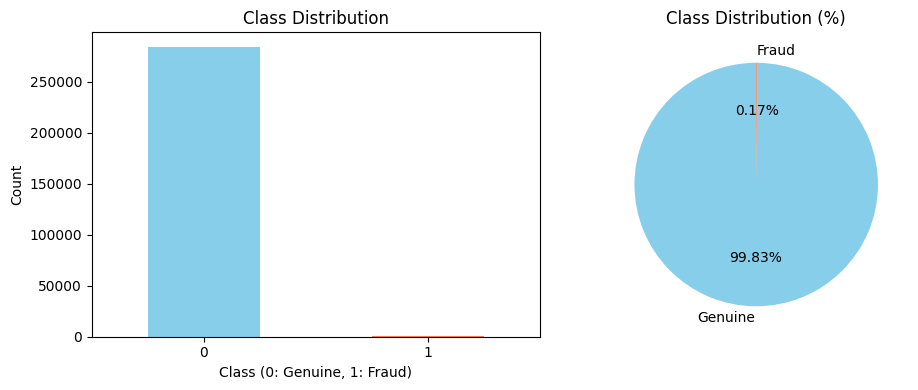


Focused Hyperparameter Tuning
Testing 162 parameter combinations
--------------------------------------------------------------------------------
[1/162] RF: estimators=50, depth=10, split=2, leaf=1, features=sqrt, bootstrap=True
Train F1: 0.9071, Test F1: 0.8743
Train Precision: 1.0000, Test Precision: 0.9412
Train Recall: 0.8299, Test Recall: 0.8163
 *** New best F1: 0.8743 ***
[2/162] RF: estimators=50, depth=10, split=2, leaf=1, features=log2, bootstrap=True
Train F1: 0.9010, Test F1: 0.8556
Train Precision: 1.0000, Test Precision: 0.9390
Train Recall: 0.8198, Test Recall: 0.7857
[3/162] RF: estimators=50, depth=10, split=2, leaf=2, features=sqrt, bootstrap=True
Train F1: 0.9003, Test F1: 0.8804
Train Precision: 0.9909, Test Precision: 0.9419
Train Recall: 0.8249, Test Recall: 0.8265
 *** New best F1: 0.8804 ***
[4/162] RF: estimators=50, depth=10, split=2, leaf=2, features=log2, bootstrap=True
Train F1: 0.8895, Test F1: 0.8603
Train Precision: 0.9907, Test Precision: 0.9506
Train

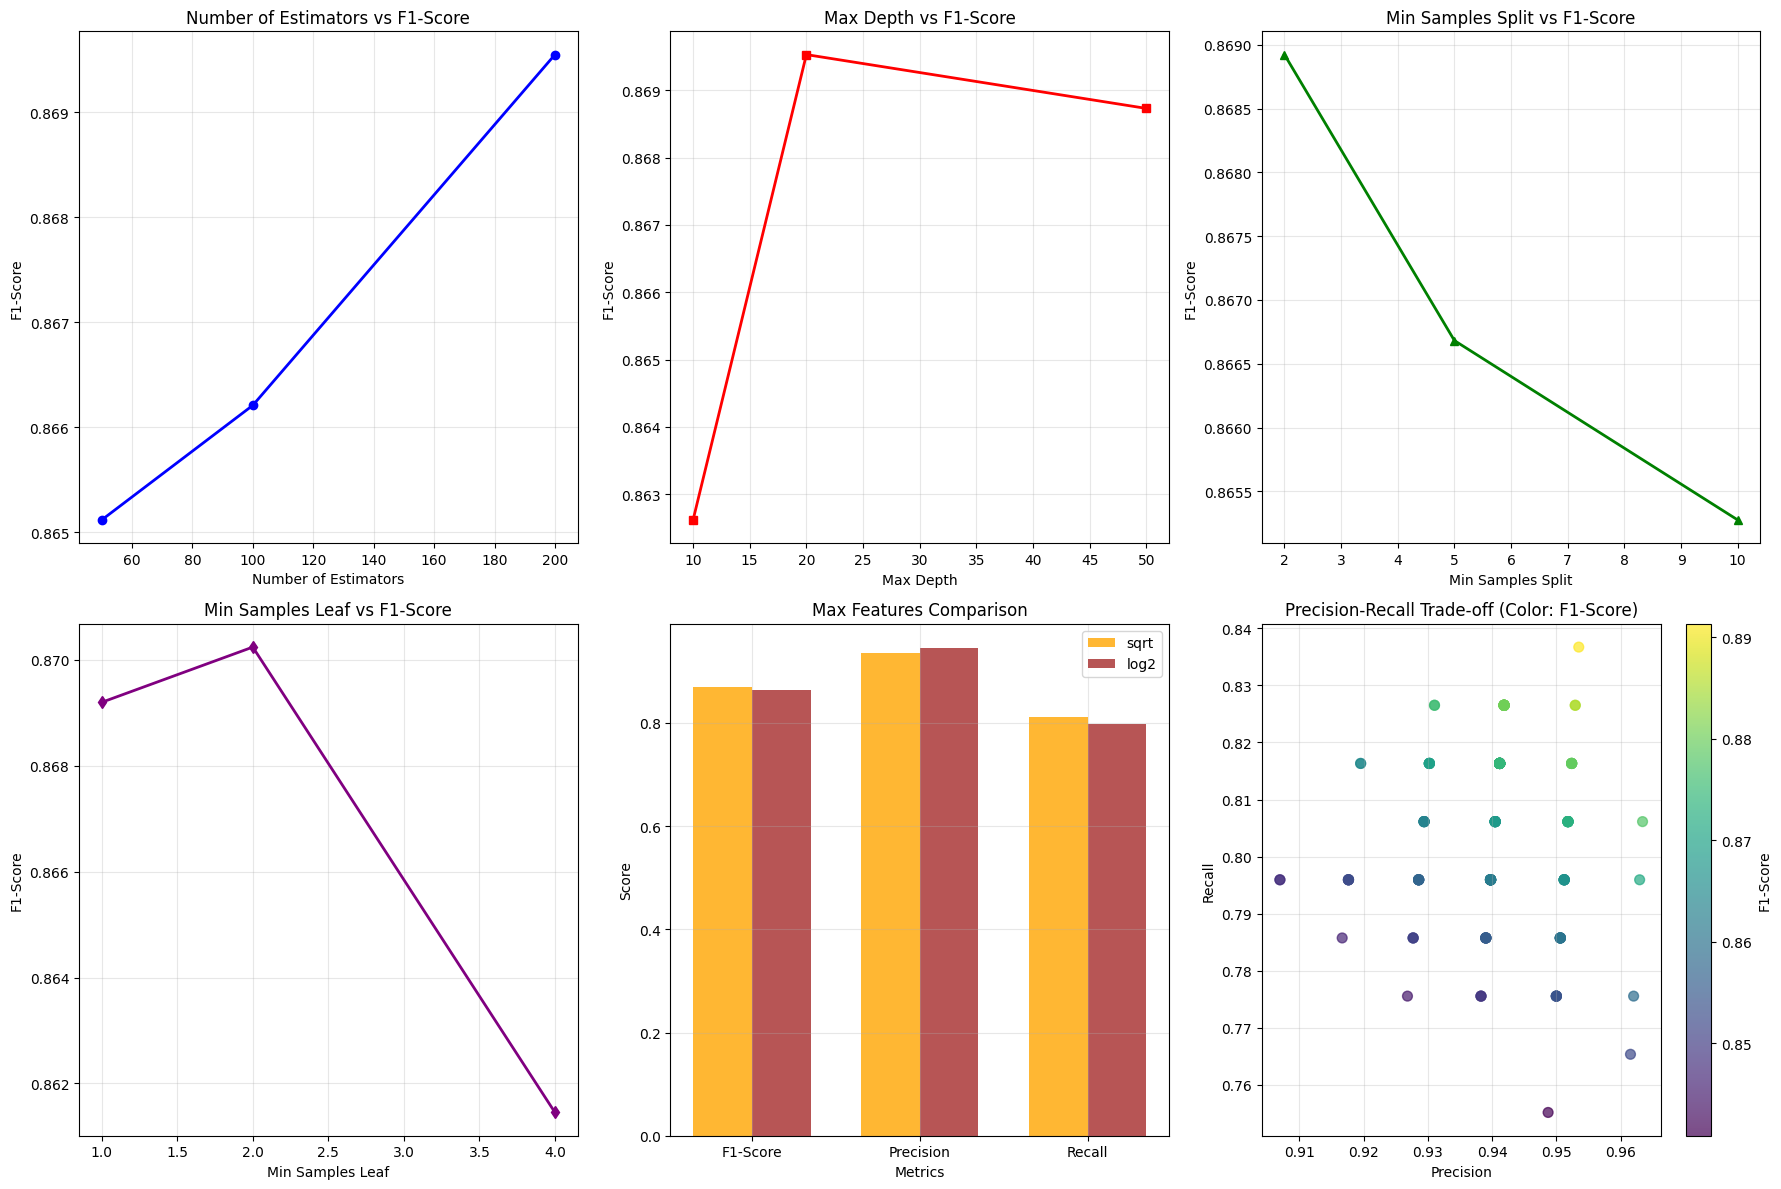

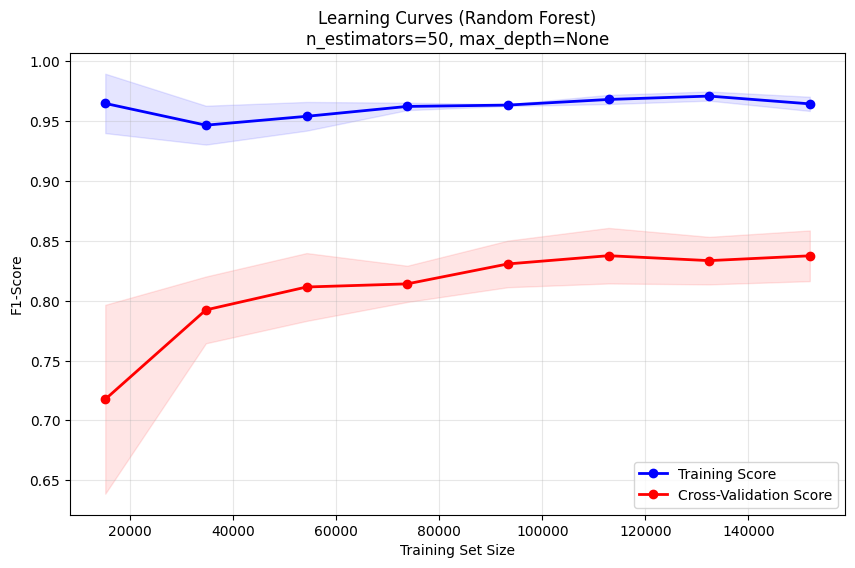

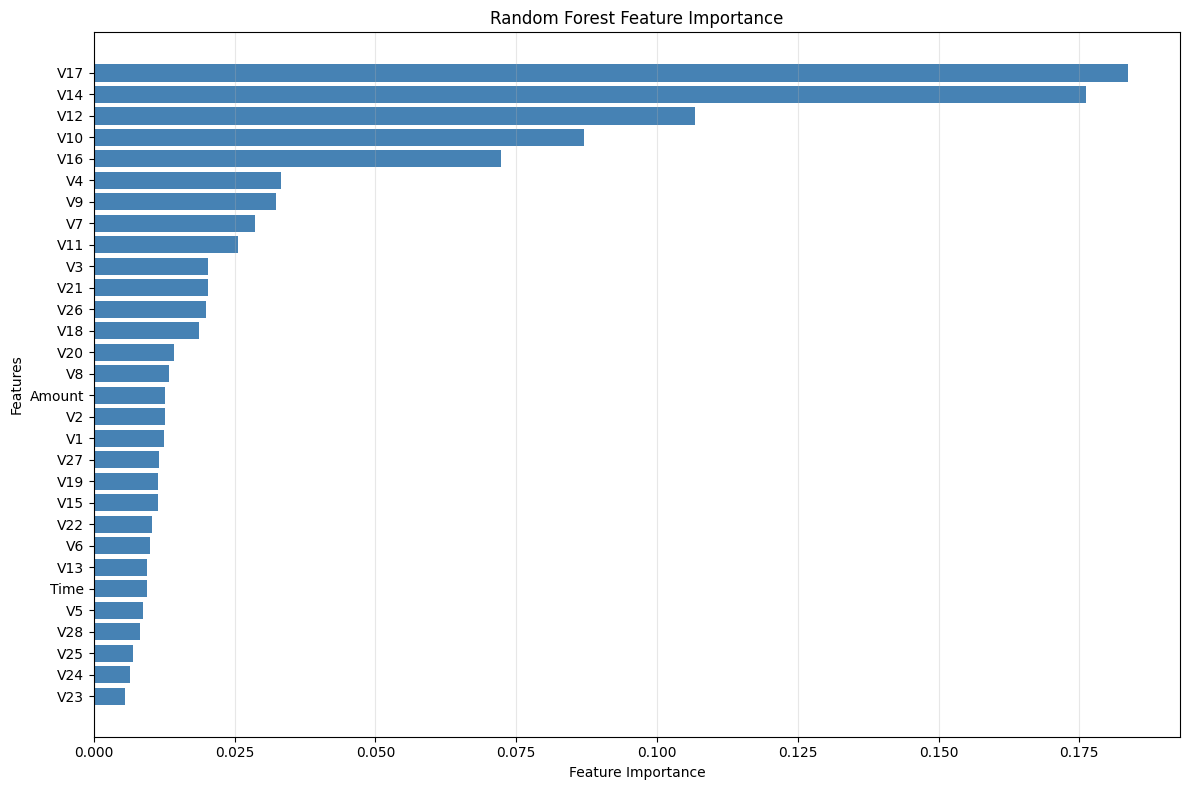


Top 10 Most Important Features:
V3: 0.0203
V11: 0.0256
V7: 0.0286
V9: 0.0324
V4: 0.0332
V16: 0.0724
V10: 0.0871
V12: 0.1067
V14: 0.1762
V17: 0.1837


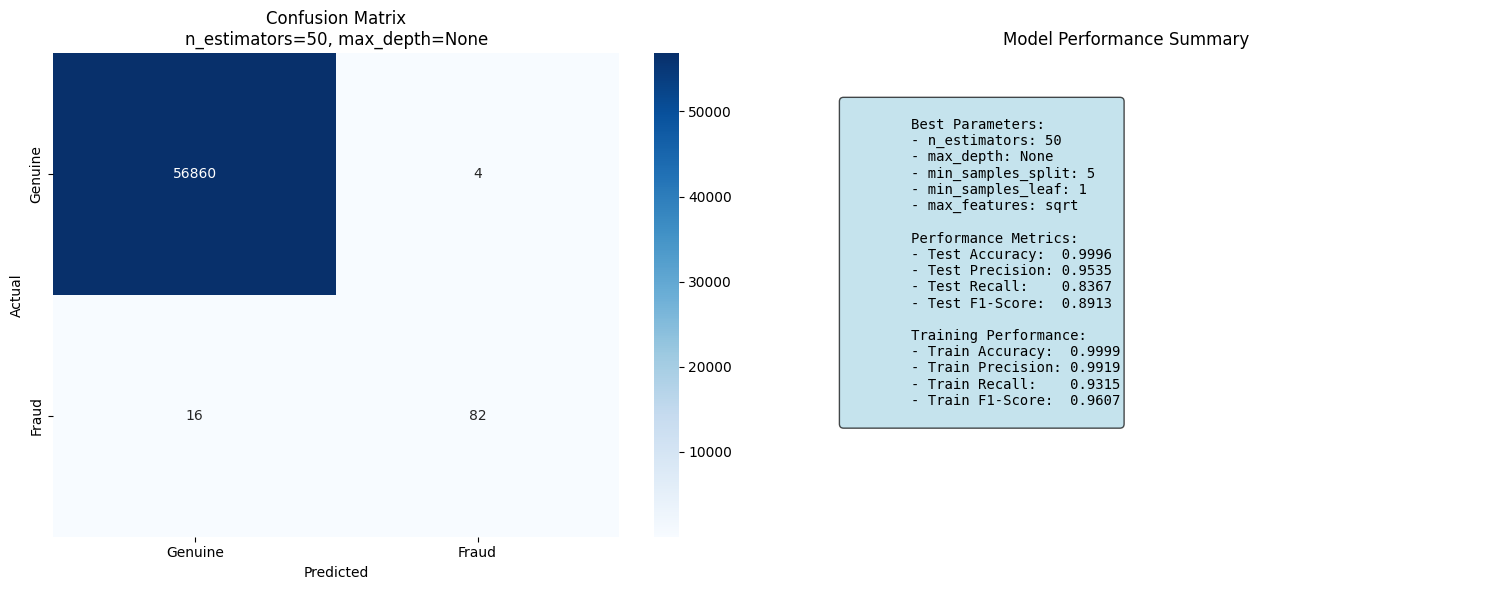

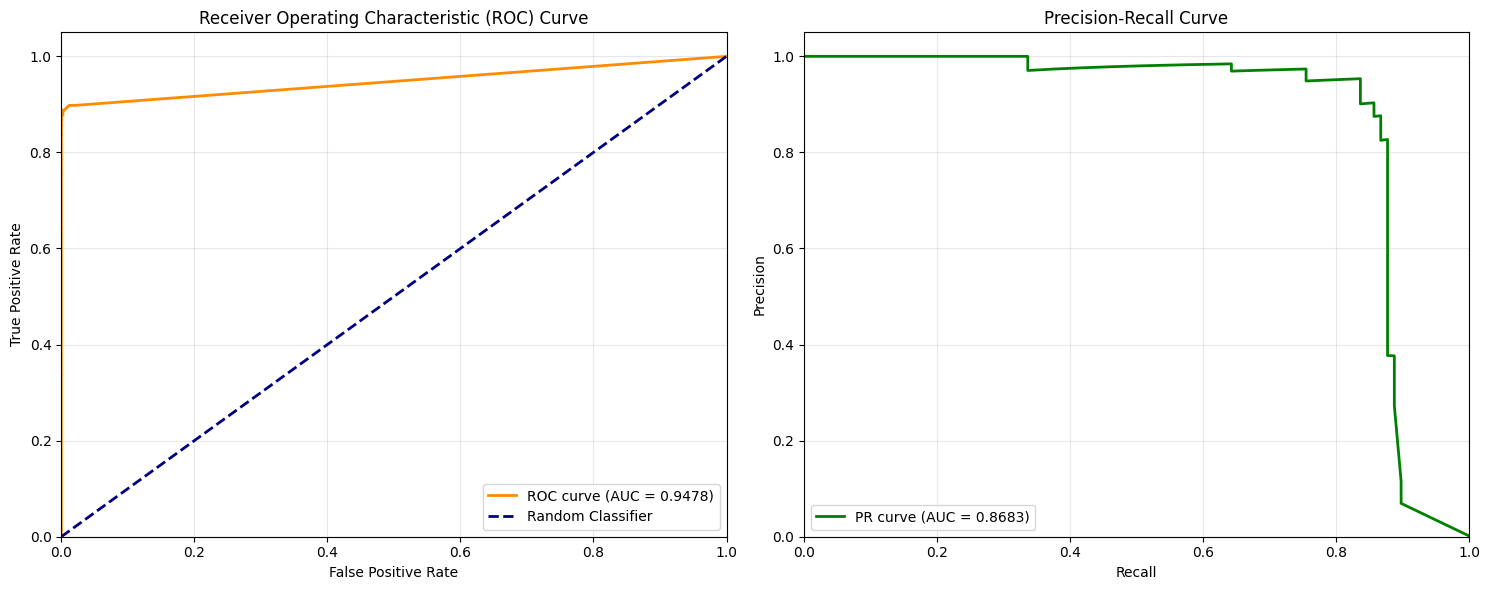


COMPREHENSIVE CLASSIFICATION REPORT
Best Parameters:
  - n_estimators: 50
  - max_depth: None
  - min_samples_split: 5
  - min_samples_leaf: 1
  - max_features: sqrt

              precision    recall  f1-score   support

     Genuine       1.00      1.00      1.00     56864
       Fraud       0.95      0.84      0.89        98

    accuracy                           1.00     56962
   macro avg       0.98      0.92      0.95     56962
weighted avg       1.00      1.00      1.00     56962


Cross-validation Scores (3-fold):
F1:       0.8392 (+/- 0.0454)
Accuracy: 0.9995 (+/- 0.0002)
Precision: 0.9279 (+/- 0.0843)
Recall:    0.7665 (+/- 0.0280)

FINAL MODEL SUMMARY
Best Parameters:
  - n_estimators: 50
  - max_depth: None
  - min_samples_split: 5
  - min_samples_leaf: 1
  - max_features: sqrt

Test Performance:
  - Accuracy:  0.9996
  - Precision: 0.9535
  - Recall:    0.8367
  - F1-Score:  0.8913

RANDOM FOREST PERFORMANCE ANALYSIS
Key Insights:
- Random Forest generally performs bette

In [3]:
# Cell 3: Run the Complete Pipeline
print("Starting Credit Card Fraud Detection with Random Forest...")

# Initialize the fraud detection system
fraud_detector = CreditCardFraudDetectionRF()

# Create directories first
fraud_detector.create_directories()

# Load and preprocess data
fraud_detector.load_data()

# Analyze class imbalance
fraud_detector.analyze_class_imbalance()

# Perform focused hyperparameter tuning
best_params = fraud_detector.hyperparameter_tuning_focused()

# Plot hyperparameter analysis
fraud_detector.plot_hyperparameter_analysis()

# Plot learning curves
fraud_detector.plot_learning_curves()

# Plot feature importance
fraud_detector.plot_feature_importance()

# Plot comprehensive confusion matrix
fraud_detector.plot_confusion_matrix_comprehensive()

# Plot ROC and PR curves
fraud_detector.plot_roc_pr_curves()

# Print comprehensive report
fraud_detector.print_comprehensive_report()

# Print final summary
print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
results = best_params['results']
print(f"Best Parameters:")
print(f"  - n_estimators: {best_params['n_estimators']}")
print(f"  - max_depth: {best_params['max_depth']}")
print(f"  - min_samples_split: {best_params['min_samples_split']}")
print(f"  - min_samples_leaf: {best_params['min_samples_leaf']}")
print(f"  - max_features: {best_params['max_features']}")
print(f"\nTest Performance:")
print(f"  - Accuracy:  {results['test_accuracy']:.4f}")
print(f"  - Precision: {results['test_precision']:.4f}")
print(f"  - Recall:    {results['test_recall']:.4f}")
print(f"  - F1-Score:  {results['test_f1']:.4f}")

print("\n" + "="*60)
print("RANDOM FOREST PERFORMANCE ANALYSIS")
print("="*60)
print("Key Insights:")
print("- Random Forest generally performs better than single Decision Trees")
print("- Ensemble method reduces overfitting through bagging")
print("- Feature importance reveals most predictive features")
print("- Optimal parameters balance model complexity and generalization")
print("- Good performance on imbalanced datasets due to ensemble nature")

print("All steps completed successfully!")